Epoch: 0 	Batch: 0 	Loss: 2.3032760620117188
Epoch: 0 	Batch: 1 	Loss: 2.303647041320801
Epoch: 0 	Batch: 2 	Loss: 2.3006322383880615
Epoch: 0 	Batch: 3 	Loss: 2.304037094116211
Epoch: 0 	Batch: 4 	Loss: 2.3008601665496826
Epoch: 0 	Batch: 5 	Loss: 2.3031060695648193
Epoch: 0 	Batch: 6 	Loss: 2.303215980529785
Epoch: 0 	Batch: 7 	Loss: 2.3079707622528076
Epoch: 0 	Batch: 8 	Loss: 2.302088499069214
Epoch: 0 	Batch: 9 	Loss: 2.3019394874572754
Epoch: 0 	Batch: 10 	Loss: 2.3053698539733887
Epoch: 0 	Batch: 11 	Loss: 2.303879737854004
Epoch: 0 	Batch: 12 	Loss: 2.3077709674835205
Epoch: 0 	Batch: 13 	Loss: 2.305835723876953
Epoch: 0 	Batch: 14 	Loss: 2.301724433898926
Epoch: 0 	Batch: 15 	Loss: 2.3070297241210938
Epoch: 0 	Batch: 16 	Loss: 2.301093578338623
Epoch: 0 	Batch: 17 	Loss: 2.305041790008545
Epoch: 0 	Batch: 18 	Loss: 2.304002523422241
Epoch: 0 	Batch: 19 	Loss: 2.301743507385254
Epoch: 0 	Batch: 20 	Loss: 2.305701971054077
Epoch: 0 	Batch: 21 	Loss: 2.3016796112060547
Epoch: 0 	

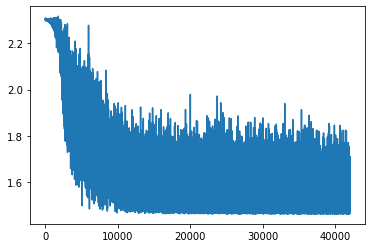

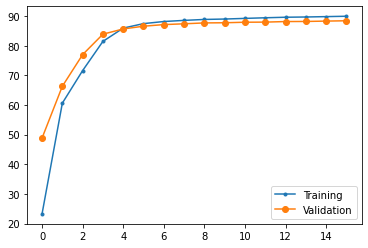

In [14]:

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter

# # SET UP TRAINING VISUALISATION
# writer = SummaryWriter(log_dir='runsCNN')


class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,
                            out_channels=10,
                            kernel_size=3),   # output 10*26*26
            #torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=10,
                            out_channels=1,
                            kernel_size=13),  # output is 1x14x14 4x21x21   4*24*24
            #torch.nn.ReLU(),
            # torch.nn.MaxPool2d(kernel_size=3),  # output is 16*8*8=1024
            torch.nn.Flatten(),
            torch.nn.Linear(196, 10),
            torch.nn.Softmax()
        )

    def forward(self, x):
        x = self.layers(x)
        #print(x.shape)
        return x

batch_size=16 #256
train_dataset = datasets.MNIST(root='MNIST-data',
                               transform=transforms.ToTensor(),
                               train=True,
                               download=True)

train_data, val_data = torch.utils.data.random_split(
    train_dataset, [int(0.7*len(train_dataset)), int(0.3*len(train_dataset))])

train_loader = torch.utils.data.dataloader.DataLoader(
    train_data, batch_size, shuffle=True)

val_loader = torch.utils.data.dataloader.DataLoader(
    val_data, batch_size, shuffle=True)

cnn_minst = CNN()

def train(model, epochs, train_loader):
    losses = []
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_ce = F.cross_entropy
    acc_train = []
    acc_val = []
#     a_val=0     Don't put them here, you need to reset them for every epoch! :P
#     a_train=0
    dircnn='runsCNN2'
    writer = SummaryWriter(log_dir=f'{dircnn}/Loss') #plot
#     writer2 = SummaryWriter(log_dir=f'{dircnn}/Accuracy/train')
#     writer3 = SummaryWriter(log_dir=f'{dircnn}/Accuracy/val')



    for epoch in range(epochs):
        a_train=0
        for idx, batch in enumerate(train_loader):
            X, y = batch
            y_pred = model(X)
            loss = loss_ce(y_pred, y)
            # print(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #print(idx, loss.item())
            print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss.item())

            y_pred2 = model(X)
            a_train += np.sum(np.array(torch.argmax(y_pred2, dim=1) == y))
            
            # SET UP TRAINING VISUALISATION
            #canvas:
            writer.add_scalar(f'Loss/Train_batchsize:{batch_size}_epochs:{epochs}', loss, epoch*len(train_loader) + idx)    # write loss to a graph
            
            losses.append(loss)
        a_train_percentage=a_train/len(train_data)*100
        
        # COMPUTE accuracy  ON VALIDATION SET
        a_val = 0 #Reset to zero at the start of each epochs
        for indx,val_batch in enumerate(val_loader):
            x, y = val_batch  # (x, y)
            # makew a prediction
            y_pred = model(x)
            
            #testing other way of obtaining a_val (accuracy using validation dataset)
            ######
            predictions = model(x)
            predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
            predictions = predictions[1]                    # torch.max returns (values, indices)
            a_val += int(sum(predictions == y))
            
            ######
            
            
            ####a_val += np.sum(np.array(torch.argmax(y_pred,dim=1) == y))
            #print(torch.argmax(y_pred))
            #print(torch.argmax(y_pred,dim=1))
            #print("arrayboolean",np.array(torch.argmax(y_pred,dim=1) == y))
            #print(" correct:", a_val)

        a_val_percentage=a_val/len(val_data)*100
        #print("total num correct:", a_val)
        #print("num_examples:", len(val_data))
        print("percentage_val:",a_val_percentage)
        
        acc_train.append(a_train_percentage)
        acc_val.append(a_val_percentage)
        
        writer = SummaryWriter(log_dir=f'{dircnn}/Accuracy/train')
        writer.add_scalar(f'Accuracy/batchsize:{batch_size}_epochs:{epochs}',np.array(a_train_percentage), epoch)
        print("percentage_train:",a_train_percentage)
        
        writer = SummaryWriter(log_dir=f'{dircnn}/Accuracy/val')
        writer.add_scalar(f'Accuracy/batchsize:{batch_size}_epochs:{epochs}',np.array(a_val_percentage), epoch)
        
        #losses.append(loss)
    writer.close()
    #writer2.close()
    #writer3.close()

    return losses, acc_train, acc_val


losses, acc_train, acc_val = train(cnn_minst, 16, train_loader)

plt.plot(losses)
#plt.plot(acc_train, c='r', label='Training')
#plt.plot(acc_val, c='b', label='Validation')
plt.show()
# plt.figure(figsize=(20, 15))plt.plot(X, Y, c='r', label='Label')
# plt.scatter(X, y_hat, c='b', label='Estimation', marker='x')



plt.plot(acc_train, '.-', label='Training')
plt.plot(acc_val, 'o-', label='Validation')
plt.legend()
plt.show()

In [9]:
list(enumerate(acc_val) )

[(0, 32.227777777777774),
 (1, 68.28888888888889),
 (2, 76.75),
 (3, 78.71666666666667),
 (4, 79.75555555555556),
 (5, 80.35),
 (6, 80.78888888888889),
 (7, 81.01666666666667),
 (8, 81.27222222222223),
 (9, 81.41111111111111),
 (10, 81.64444444444445),
 (11, 81.74444444444444),
 (12, 81.81111111111112),
 (13, 81.97222222222223),
 (14, 81.94444444444444),
 (15, 82.09444444444445),
 (16, 82.24444444444444),
 (17, 82.25),
 (18, 82.3),
 (19, 82.33888888888889),
 (20, 82.39999999999999),
 (21, 82.52222222222223),
 (22, 82.63888888888889),
 (23, 82.60555555555555),
 (24, 82.61666666666667),
 (25, 82.72222222222221),
 (26, 82.8),
 (27, 82.72777777777777)]

In [11]:
list(enumerate(acc_train) )

[(0, 24.669047619047618),
 (1, 51.17142857142857),
 (2, 73.98809523809524),
 (3, 78.16190476190476),
 (4, 79.64523809523808),
 (5, 80.35),
 (6, 80.86428571428571),
 (7, 81.24047619047619),
 (8, 81.46904761904761),
 (9, 81.69999999999999),
 (10, 81.93809523809524),
 (11, 82.09761904761905),
 (12, 82.24761904761905),
 (13, 82.41904761904762),
 (14, 82.52142857142857),
 (15, 82.59761904761905),
 (16, 82.7357142857143),
 (17, 82.7904761904762),
 (18, 82.87380952380953),
 (19, 82.95238095238095),
 (20, 82.99761904761904),
 (21, 83.12857142857143),
 (22, 83.12142857142857),
 (23, 83.20952380952382),
 (24, 83.30714285714286),
 (25, 83.34761904761905),
 (26, 83.33095238095238),
 (27, 83.40238095238095)]

In [46]:
%load_ext tensorboard
%tensorboard --logdir runsCNN2/Accuracy


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

In [43]:
%reload_ext tensorboard

In [ ]:
import numpy as np
            
def test(model):
    num_correct = 0
    a_val=0
    num_examples = len(val_data)                       # test DATA not test LOADER
    for inputs, labels in val_loader:                  # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions2 = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions2 = predictions2[1]                    # torch.max returns (values, indices)
        #print(inputs.shape)
        #print(labels.shape)
        #print(predictions.shape)
        #a_val += np.sum(np.array(torch.argmax(predictions,dim=1) == labels))
        num_correct += int(sum(predictions2 == labels))
        print(num_correct)
    percent_correct = num_correct / num_examples * 100
    print("total num correct:", num_correct)
    print("num_examples:", num_examples)
    #percent_correct2 = a_val / num_examples * 100
    
    print('Accuracy:', percent_correct)#, '/t', "Accuracy2:", percent_correct2 )
    
test(cnn_minst)

In [47]:
import threading
for thread in threading.enumerate(): 
    print(thread.name)

MainThread
Thread-2
Thread-3
IPythonHistorySavingThread
Thread-1
Thread-4
Thread-5
Thread-6
Thread-13
Thread-14
Thread-16
Thread-17
Thread-18
Thread-19
Thread-20
Thread-21
Thread-22
Thread-23
Thread-24
Thread-25
Thread-26
Thread-27
Thread-28
Thread-29
Thread-30
Thread-31
Thread-32
Thread-33
Thread-34
Thread-35
Thread-36
Thread-37
Thread-38
Thread-39
Thread-40
Thread-41
Thread-42
Thread-43
Thread-44
Thread-45
Thread-46
Thread-47


In [48]:
#https://pythonprogramming.net/python-pickle-module-save-objects-serialization/
import pickle


pickle_out = open("cnn_MINSST.pickle","wb")
pickle.dump(cnn_minst, pickle_out)
pickle_out.close()

In [52]:
pickle_in = open("cnn_MINSST.pickle","rb")
model2 = pickle.load(pickle_in)

In [53]:
  for idx, batch in enumerate(train_loader):
            X, y = batch
            y_pred = model2(X)
            print(y_pred)
            break

tensor([[6.2922e-27, 3.4729e-26, 7.3212e-11, 1.5112e-27, 7.3063e-16, 6.1004e-23,
         1.0000e+00, 1.7210e-34, 1.5060e-18, 2.9867e-28],
        [5.3650e-17, 1.9127e-18, 1.0000e+00, 1.2015e-14, 3.1056e-24, 1.4872e-17,
         2.8771e-17, 3.4646e-17, 7.2726e-13, 6.0708e-21],
        [6.1096e-16, 2.5035e-17, 4.6955e-10, 1.2096e-18, 2.6152e-08, 6.5407e-13,
         1.0000e+00, 4.4551e-19, 2.3072e-10, 1.6825e-13],
        [4.0339e-15, 5.0710e-23, 7.3169e-22, 3.0105e-19, 9.9999e-01, 1.6005e-18,
         3.2635e-07, 1.1373e-11, 6.2976e-13, 1.0016e-05],
        [4.9315e-09, 1.7221e-02, 1.0419e-06, 4.5952e-08, 2.5242e-05, 3.5765e-05,
         4.0478e-07, 8.7316e-07, 9.8271e-01, 7.5294e-06],
        [1.6131e-19, 2.9121e-26, 1.9236e-17, 6.6978e-21, 7.9244e-16, 8.7899e-12,
         1.0000e+00, 9.1366e-34, 8.8512e-11, 7.0118e-22],
        [3.1281e-03, 7.1959e-15, 2.5773e-12, 8.8411e-12, 3.2253e-11, 9.9687e-01,
         2.0845e-09, 7.5560e-12, 2.9307e-06, 3.5809e-07],
        [6.4291e-17, 1.7143